# Monte Carlo Methods

First-visit monte carlo

In [189]:
import numpy as np, matplotlib, random, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt

In [135]:
from dataclasses import dataclass

@dataclass
class Environment:
    states: list
    actions: list
    step: callable

In [276]:
class Tape:
    def __init__(self, policy:  list, environment: Environment, length: int):
        self.environment = environment
        self.policy = policy
        self.states = []
        self.actions = []
        self.rewards = [-1]
        self.length = length
        
    def playout(self, start_state):
        first_seen = dict()
        self.states = [start_state]
        self.actions = [self.policy[start_state]]
        self.rewards = [-1]
        s = self.states[0]
        a = self.actions[0]
        for i in range(1, self.length + 1): # the last s and a are ignored
            if s not in first_seen:
                first_seen.update( {s : i-1} )
            r,s = self.environment.step(s,a)
            if s is None:
                break
            self.rewards.append(r)
            self.states.append(s)
            a = self.policy[s]
            self.actions.append(a)
        self.first_seen = first_seen

In [277]:
class MonteCarlo:
    def __init__(self, policy, environment, num_steps, gamma = 1):
        self.num_steps = num_steps
        self.V = dict()
        self.V_count = dict()
        self.pi = dict()
        self.policy = policy
        self.environment= environment
        self.gamma = gamma

    def estimate_v_first_visit(self, start_state = None, max_reps = 10000):
        V = { s : 0.5 for s in self.environment.states }
        V_counts = { s : 0 for s in self.environment.states }
        tape = Tape(self.policy, self.environment, self.num_steps)
        if start_state:
            start = lambda : start_state
        else:
            start = lambda : random.choice(self.environment.states) 
        # random start
        
        loop_counter = 0
        while True:
            loop_counter += 1
            if loop_counter > max_reps:
                break
            start_state = start()
            tape.playout(start_state)
            G = 0
            max_len = len(tape.rewards)-1
            for t in range(max_len-1,-1,-1):
                G = self.gamma*G + tape.rewards[t+1]
                s = tape.states[t]
                if tape.first_seen[s] == t:
                    n = V_counts[s]
                    v = V[s]
                    v = ((n * v) + G) /(n+1)
                    V[s] = v
                    V_counts[s] += 1
        self.V = V
        self.V_counts = V_counts

In [278]:
gambler_states = list(range(101))
gambler_actions = list(range(1,100))
gambler_policy = dict()
gambler_values = dict()

with open("gambler-policy.txt","r") as f:
    text = f.readlines()
    for l in text:
        l = l.strip()
        i, x = l.split(" ")
        gambler_policy.update({int(i):int(round(float(x)))})

with open("gambler-value.txt","r") as f:
    text = f.readlines()
    for l in text:
        l = l.strip()
        i, x = l.split(" ")
        gambler_values.update({int(i):float(x)})

def gambler_step(s,a):
    if (s==0 or s==100):
        return None, None
    if (random.random() < 0.4):
        s = s + a
    else:
        s = s - a
    r = 1 if s == 100 else 0
    if (s<0 or s>100):
        raise ValueError(f"Invalid state encountered: {s}, {a}")
    return r, s
    
gambler_environment = Environment(actions = gambler_actions, states = gambler_states, step=gambler_step)

## Let's try it

In [279]:
mc = MonteCarlo(gambler_policy, gambler_environment, 10)

In [280]:
mc.estimate_v_first_visit(max_reps=100000)

In [281]:
V=[mc.V[k] for k in mc.V]
V[0] = 0
V[100] = 0

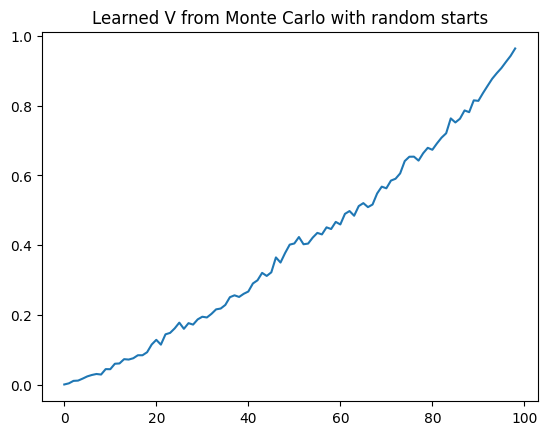

In [282]:
plt.plot(V[1:100]) # omit terminal states
plt.title("Learned V from Monte Carlo with random starts")
plt.show()

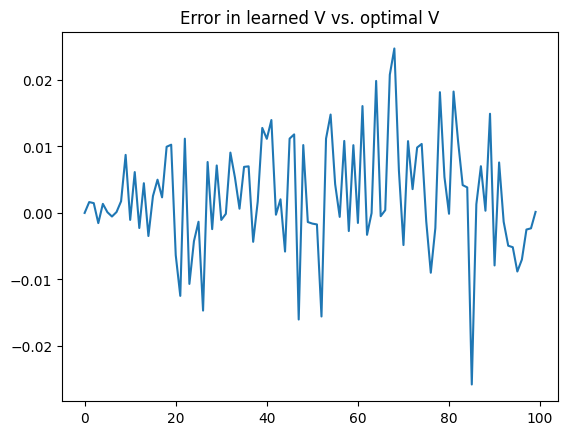

In [283]:
plt.plot(np.array([gambler_values[x] for x in gambler_values])-np.array( V[:-1]))
plt.title("Error in learned V vs. optimal V")
plt.show()

## Extract policy from V

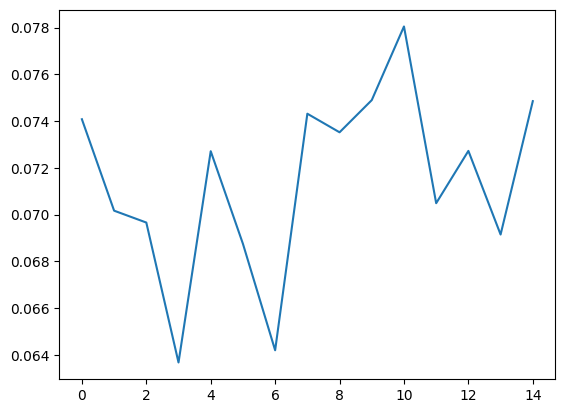

In [284]:
def actions_from_state(s):
    return list(range(1,min(s+1,101-s)))

def reward(s):
    return 1 if s==100 else 0

p_h = 0.4
gamma = 1

pi = [0]*101
for s in range(1,100):
    state_actions = actions_from_state(s)
    action_values = []
    for a in state_actions:
        action_values.append( (p_h*(reward(s+a)+gamma*V[s+a]) + (1-p_h)*(reward(s-a)+gamma*V[s-a]),a) )
    if (s==15):
        plt.plot([x[0] for x in action_values])
    best_action = max(action_values, key=lambda x:(x[0],-x[1]))[1]
    pi[s] = best_action

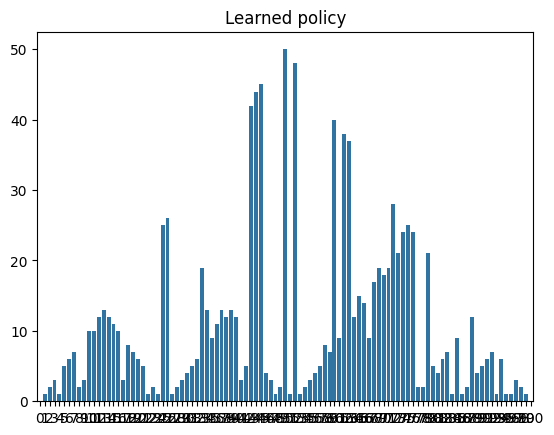

In [285]:
sns.barplot(pi)
plt.title("Learned policy")
plt.show()

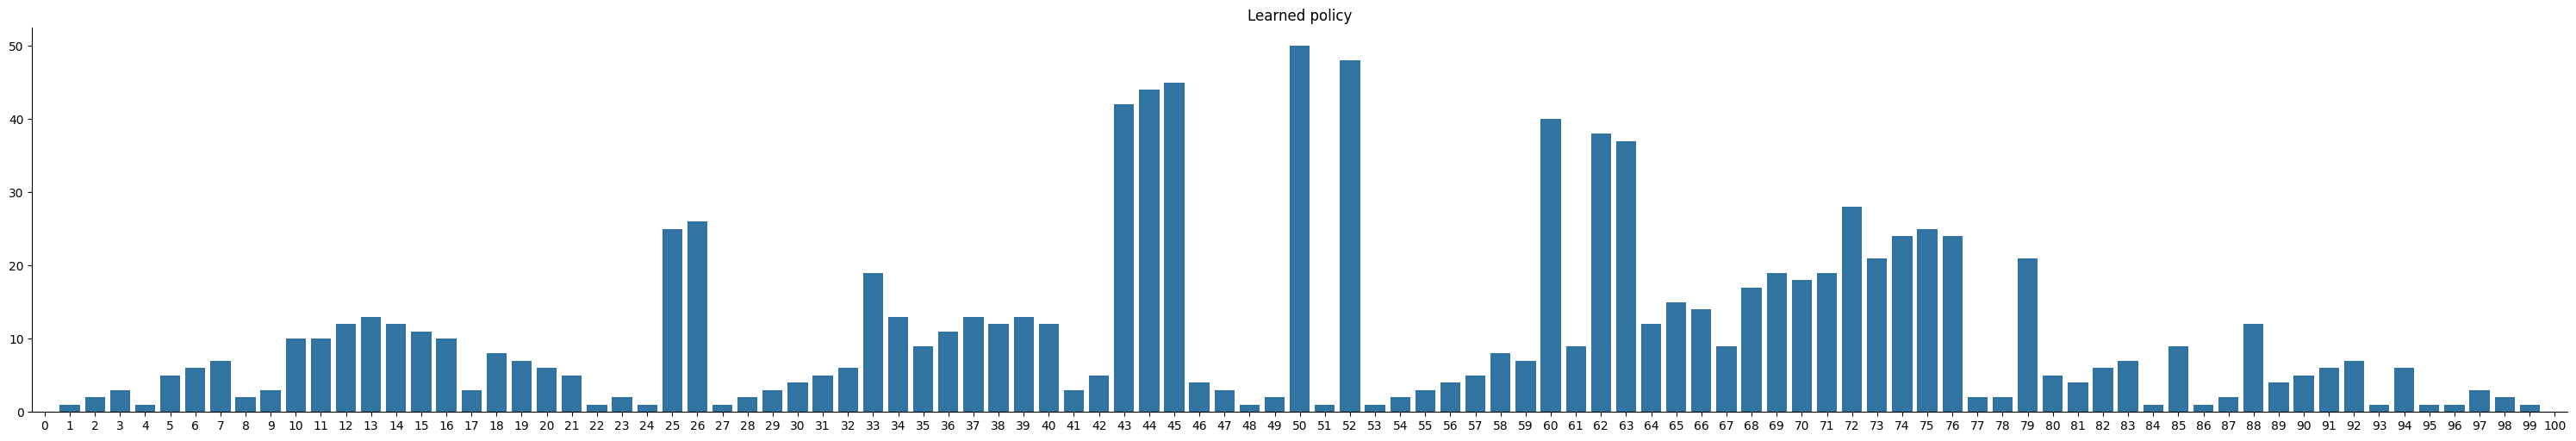

In [286]:
df = pd.DataFrame({
    'state': range(0,101),
    'action': pi
})

# Create a wide bar plot
sns.catplot(pi, kind='bar', aspect=6)  # aspect ratio set to 2 for a wider plot
plt.title("Learned policy")
plt.show()

## Evaluate Policy

First evaluate the optimal policy

In [321]:
tape = Tape(gambler_policy, gambler_environment, 20)

plays = 10000
results = 0
for i in range(plays):
    tape.playout(random.choice(gambler_environment.states))
    results += sum(tape.rewards[1:])
print("Avg number of wins: ", results/plays)

Avg number of wins:  0.3859


And now the learned policy from Monte Carlo

In [318]:
tape = Tape(pi, gambler_environment, 20) 

plays = 10000
results = 0
for i in range(plays):
    tape.playout(random.choice(gambler_environment.states))
    results += sum(tape.rewards[1:])
print("Avg number of wins: ", results/plays)

Avg number of wins:  0.3862


Finally the simple "max bet" policy

In [323]:
dumb_pi = [min(x,100-x) for x in range(101)]
tape = Tape(dumb_pi, gambler_environment, 20) 

plays = 10000
results = 0
for i in range(plays):
    tape.playout(random.choice(gambler_environment.states))
    results += sum(tape.rewards[1:])
print("Avg number of wins: ", results/plays)

Avg number of wins:  0.3921


They all look about the same. Let's try again but only start with $1.

In [344]:
tape = Tape(gambler_policy, gambler_environment, 20)

plays = 1000000
results = 0
for i in range(plays):
    tape.playout(1)
    results += sum(tape.rewards[1:])
print("Avg number of wins: ", results/plays)

Avg number of wins:  0.002055


In [345]:
tape = Tape(pi, gambler_environment, 20) 

plays = 1000000
results = 0
for i in range(plays):
    tape.playout(1)
    results += sum(tape.rewards[1:])
print("Avg number of wins: ", results/plays)

Avg number of wins:  0.001966


In [346]:
dumb_pi = [min(x,100-x) for x in range(101)]
tape = Tape(dumb_pi, gambler_environment, 20) 

plays = 1000000
results = 0
for i in range(plays):
    tape.playout(1)
    results += sum(tape.rewards[1:])
print("Avg number of wins: ", results/plays)

Avg number of wins:  0.002087


## GPT stuff

In [347]:
def value_iteration(goal=100, prob_heads=0.4):
    values = [0] * (goal + 1)
    values[goal] = 1  # Goal reached
    
    while True:
        delta = 0
        for s in range(1, goal):
            old_value = values[s]
            best_value = 0
            for bet in range(1, min(s, goal-s) + 1):
                win = s + bet
                lose = s - bet
                value = prob_heads * values[win] + (1 - prob_heads) * values[lose]
                best_value = max(best_value, value)
            values[s] = best_value
            delta = max(delta, abs(old_value - values[s]))
        
        if delta < 1e-19:
            break
    
    return values

# Calculate the value function for the gambler's problem
values = value_iteration()
print(f"Probability of reaching the goal starting with $1: {values[1]:.4f}")


Probability of reaching the goal starting with $1: 0.0021


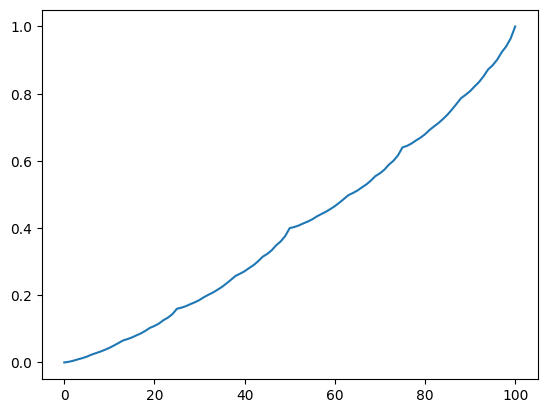

In [348]:
plt.plot(values)
plt.show()